In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from scipy.stats import norm

torch.set_printoptions(sci_mode=False)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def black_scholes_mc(S0, K, T, r, sigma, nb_trajectories, nb_steps, d, rho):
    dt = T / nb_steps

    dB = torch.sqrt(dt) * torch.randn(nb_trajectories, nb_steps, d)
    Sigma = torch.full((d, d), rho) + (1 - rho) * torch.eye(d)
    L = torch.linalg.cholesky(Sigma)
    dW = torch.einsum('ijk,kl->ijl', dB, L.T)


    S = torch.ones((nb_trajectories, nb_steps + 1, d)) * S0

    for i in tqdm(range(1, nb_steps + 1)):
        dSi = r * S[:, i-1, :] * dt + sigma * S[:, i-1, :] * dW[:, i-1, :]
        S[:, i, :] = S[:, i-1, :] + dSi
    return S

In [3]:
#Les payoff de chaque option
def basket_call_payoff(S, weights, K):
    valeur_basket = torch.sum(weights * S[:, -1, :], dim=1)
    return torch.exp(-r*T)*torch.maximum(valeur_basket - K, torch.tensor(0.0))

def digital_option_payoff(S, weights, K):
    valeur_digital = torch.sum(weights * S[:, -1, :], dim=1)
    return torch.exp(-r*T)*torch.where(valeur_digital >= K, torch.tensor(1.0), torch.tensor(0.0)) * torch.tensor(G)

def asian_option_payoff(S, weights, K):
    valeur_asian = torch.mean(torch.sum(weights * S, dim=-1), dim=-1)
    return torch.exp(-r*T)*torch.maximum(valeur_asian - K, torch.tensor(0.0))

def worst_of_put_payoff(S, K):
    valeur_worst = torch.min(S[:, -1, :], dim=1).values
    return torch.exp(-r*T)*torch.maximum(K - valeur_worst, torch.tensor(0.0))

In [4]:
# Paramètres
S0 = 100.0
K = 100.0
T = torch.tensor(1.0)
r = torch.tensor(0.05)
sigma = 0.4
rho = 0.75
d = 10
nb_trajectoires = 10000
nb_steps = 101
weights = torch.ones(d) / d
G = 100

100%|███████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 658.37it/s]


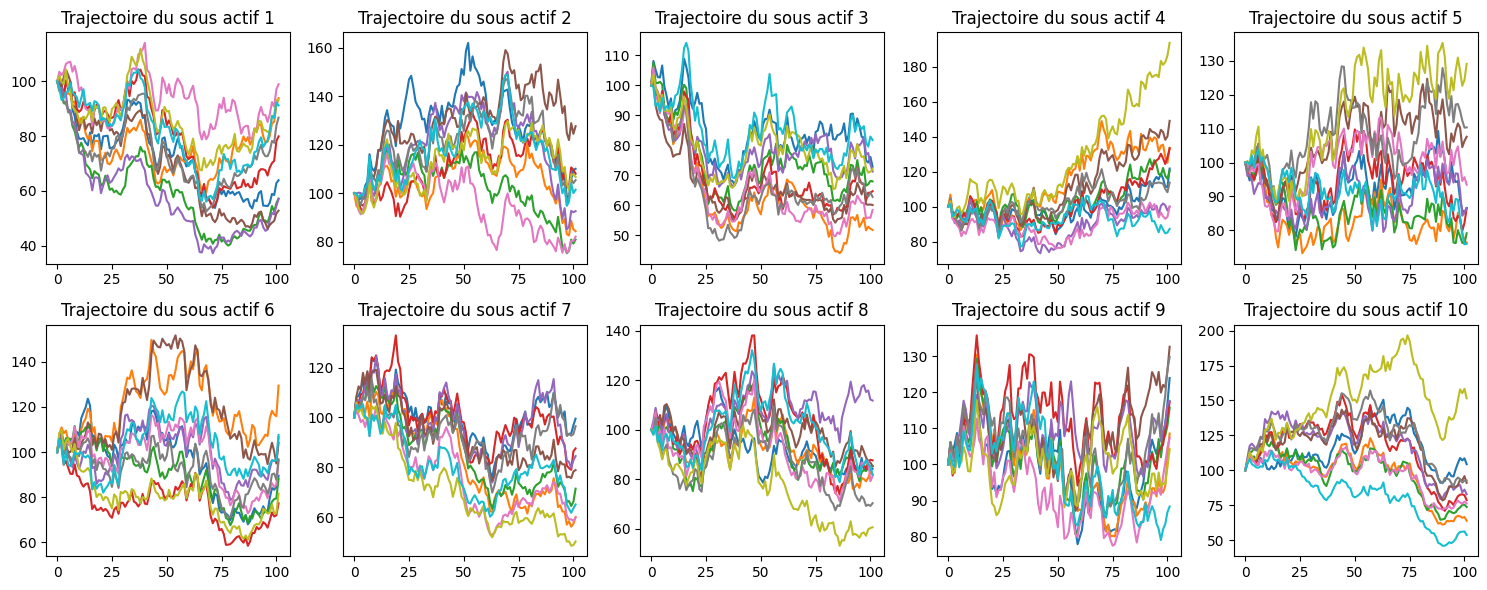

In [5]:
S = black_scholes_mc(S0, K, T, r, sigma, nb_trajectoires, nb_steps, d, rho)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

#On trace les différentes trajectoires du marché
for i, ax in enumerate(axes.flatten()):
    if i < nb_trajectoires:
        ax.plot(S[i, :, :])
        ax.set_title(f'Trajectoire du sous actif {i + 1}')

plt.tight_layout()
plt.show()

# Monte Carlo

In [6]:
#On stocke les payoff de chaque option
basket_call_prices = basket_call_payoff(S, weights, K)
asian_option_prices = asian_option_payoff(S, weights, K)
digital_option_prices = digital_option_payoff(S, weights, K)
worst_of_put_prices = worst_of_put_payoff(S, K)

def calcul_IC(prices, alpha=0.95):
    mean_price = torch.mean(prices)
    std_dev = torch.std(prices)
    n = len(prices)
    z = np.abs(np.percentile(np.random.normal(0, 1, n), (1 - alpha / 2, alpha / 2)))

    lower_bound = mean_price - z[0] * (std_dev / np.sqrt(n))
    upper_bound = mean_price + z[1] * (std_dev / np.sqrt(n))

    return mean_price, lower_bound, upper_bound

# Affichage des résultats avec intervalles de confiance
print(f"Monte Carlo price pour Basket Call Option: {torch.round(calcul_IC(basket_call_prices)[0], decimals = 2)} "
      f"({torch.round(calcul_IC(basket_call_prices)[1], decimals = 2)}, "
      f"{torch.round(calcul_IC(basket_call_prices)[2], decimals = 2)})")

print(f"Monte Carlo price pour Asian Option: {torch.round(calcul_IC(asian_option_prices)[0], decimals = 2)} "
      f"({torch.round(calcul_IC(asian_option_prices)[1] , decimals = 2)}, "
      f"{torch.round(calcul_IC(asian_option_prices)[2] , decimals = 2)})")

print(f"Monte Carlo price pour Digital Option: {torch.round(calcul_IC(digital_option_prices)[0], decimals = 2)} "
      f"({torch.round(calcul_IC(digital_option_prices)[1] , decimals = 2)}, "
      f"{torch.round(calcul_IC(digital_option_prices)[2] , decimals = 2)})")

print(f"Monte Carlo price pour Worst Of Put Option: {torch.round(calcul_IC(worst_of_put_prices)[0] , decimals = 2)} "
      f"({torch.round(calcul_IC(worst_of_put_prices)[1], decimals = 2)}, "
      f"{torch.round(calcul_IC(worst_of_put_prices)[2], decimals = 2)})")

Monte Carlo price pour Basket Call Option: 16.170000076293945 (15.479999542236328, 16.8700008392334)
Monte Carlo price pour Asian Option: 9.109999656677246 (8.739999771118164, 9.479999542236328)
Monte Carlo price pour Digital Option: 45.81999969482422 (44.619998931884766, 47.040000915527344)
Monte Carlo price pour Worst Of Put Option: 26.760000228881836 (26.25, 27.270000457763672)


### Méthode 1 | Réduction dimension

In [7]:
class DimensionReductionNetwork(nn.Module):
    def __init__(self, input_dim, reduction_dim, output_dim):
        super(DimensionReductionNetwork, self).__init__()
        self.reduction_layer = nn.Linear(input_dim, reduction_dim, bias=False)
        self.reconstitution_layer = nn.Linear(reduction_dim, output_dim)

    def forward(self, x):
        z_tilde = self.reduction_layer(x)
        reconstructed_output = self.reconstitution_layer(torch.relu(z_tilde))
        return z_tilde

In [9]:
#Toute cette partie est assez mal faite mais elle ne fonctionnait pas dans tous les cas, nous avons donc essayé de faire un code
#beaucoup plus propre sur la deuxième méthode

model_basket_call_dim = DimensionReductionNetwork(input_size, hidden_size1, output_size)
model_digital_option_dim = DimensionReductionNetwork(input_size, hidden_size1, output_size)
model_worst_of_put_dim = DimensionReductionNetwork(input_size, hidden_size1, output_size)
model_asian_option_dim = DimensionReductionNetwork(input_size, hidden_size1, output_size)

model_basket_call.to(device)
model_digital_option.to(device)
model_worst_of_put.to(device)
model_asian_option.to(device)

list_model = [model_basket_call_dim, model_digital_option_dim, model_worst_of_put_dim, model_asian_option_dim]

S = black_scholes_mc(S0, K, T, r, sigma, nb_trajectories, nb_steps, d, rho)
N = d
n = 3

#Entrainement du modèle
def train(list_model, epoch, batch_size, lr=0.001):
    for i in list_model:
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr)

        Z = torch.randn(nb_trajectories, N)

        for epoch in range(100):
            optimizer.zero_grad()
            Z_reduced = model(Z)
            loss = criterion(Z_reduced, torch.zeros_like(Z_reduced))
            loss.backward()
            optimizer.step()

NameError: name 'input_size' is not defined

In [10]:
train(list_model, 50, batch_size, lr=0.001)

NameError: name 'train' is not defined

In [11]:
# Obtenir la matrice U normalisée
U_normalized = model.reduction_layer.weight.data / torch.norm(model.reduction_layer.weight.data, dim=1, keepdim=True)
def gaussian_elimination(U):
    n, N = U.shape
    I = torch.eye(N)
    augmented_matrix = torch.cat((U, I), dim=0)

    for col in range(N):
        pivot_row = col
        for row in range(col + 1, n + N):
            if augmented_matrix[row, col] != 0:
                pivot_row = row
                break

        augmented_matrix[[col, pivot_row]] = augmented_matrix[[pivot_row, col]]

        for row in range(n + N):
            if row != col:
                factor = augmented_matrix[row, col] / augmented_matrix[col, col]
                augmented_matrix[row] -= factor * augmented_matrix[col]
    return augmented_matrix[n:, n:].t()

V= gaussian_elimination(U_normalized)
print(V.shape)
print(U_normalized.shape)
#Erreur on devrait trouver V de dimension N-n*N
Z_reduced = torch.matmul(Z, U_normalized.T)

# Simulation de Z_orthogonal
Z_orthogonal = torch.matmul(Z, V.T)
M=torch.cat((U_normalized, V), dim=0)


NameError: name 'model' is not defined

### Méthode 2 | Variable de contrôle

In [12]:
## Hyper paramètres
Propotion_X_train = int(0.8*S.shape[0])
input_size = (nb_steps+1)*d
hidden_size1 = 256
output_size = 1
batch_size = 128

In [13]:
#Création des différents modèles
class NeuralNetwork_Analytic_Integration(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size):
        super(NeuralNetwork_Analytic_Integration, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

model_basket_call = NeuralNetwork_Analytic_Integration(input_size, hidden_size1, output_size)
model_digital_option = NeuralNetwork_Analytic_Integration(input_size, hidden_size1, output_size)
model_worst_of_put = NeuralNetwork_Analytic_Integration(input_size, hidden_size1, output_size)
model_asian_option = NeuralNetwork_Analytic_Integration(input_size, hidden_size1, output_size)

model_basket_call.to(device)
model_digital_option.to(device)
model_worst_of_put.to(device)
model_asian_option.to(device)

NeuralNetwork_Analytic_Integration(
  (layer1): Linear(in_features=1020, out_features=256, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=256, out_features=1, bias=True)
)

In [14]:
class OptionDataset(Dataset):
            def __init__(self, inputs, targets):
                self.inputs = inputs
                self.targets = targets

            def __len__(self):
                return len(self.inputs)

            def __getitem__(self, idx):
                return self.inputs[idx], self.targets[idx]

def train(list_model, nb_epochs, batch_size, lr=0.001):
    i = 0
    for model in list_model:
        X_train = S[:Propotion_X_train,:,:]
        X_test = S[Propotion_X_train:,:,:]
        if i == 0:
            y_train = basket_call_payoff(X_train, weights, K)
            y_test = basket_call_payoff(X_test, weights, K)
        elif i == 1:
            y_train = digital_option_payoff(X_train, weights, K)
            y_test = digital_option_payoff(X_test, weights, K)
        elif i == 2:
            y_train = worst_of_put_payoff(X_train, K)
            y_test = worst_of_put_payoff(X_test, K)
        else:
            y_train = asian_option_payoff(X_train, weights, K)
            y_test = asian_option_payoff(X_test, weights, K)
        i = i+1
        #Pour passer les tensor sur le gpu
        X_train = X_train.to(device)
        X_test = X_test.to(device)
        y_train = y_train.to(device)
        y_test = y_test.to(device)

        X_train=X_train.view(X_train.shape[0],-1)
        y_train =y_train.view(Propotion_X_train,1)
        y_test =y_test.view(S.shape[0]-Propotion_X_train,1)
        X_test=X_test.view(X_test.shape[0],-1)
        
        train_dataset = OptionDataset(X_train, y_train)
        test_dataset = OptionDataset(X_test, y_test)
        
        train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

        optimizer = torch.optim.Adam(model.parameters(), lr)

        criterion = torch.nn.MSELoss()

        epochs = nb_epochs
        train_loss = []
        test_loss = []

        for epoch in tqdm(range(epochs)):
            model.train()

            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss_test = criterion(outputs, targets)

            if epoch % 10 == 0:
                print(f"Epoch: {epoch} | Train Loss: {loss} | Test Loss: {loss_test}")
                train_loss.append(loss.item())
                test_loss.append(loss_test.item())

        plt.plot(range(len(train_loss)), train_loss, label=f'Modèle {i}')

In [15]:
train(list_model,5,128)

#changer epochs=5 à au moins 50 pour avoir un graphe

NameError: name 'list_model' is not defined

In [16]:
#Dans cette cellule nous comparons les payoff pour une trajectoire de l'actif entre le modèle et la fonction du payoff
list_model = [("Call Basket", model_basket_call), ("Digital Option", model_digital_option),
              ("Put Worst of max", model_worst_of_put), ("Arithmetic Asian", model_asian_option)]

random_number = np.random.randint(0,S.shape[0])

print("trajectoire numero " + str(random_number))
random_trajectoire = S[random_number,: ,:]

random_trajectoire = random_trajectoire.reshape(1, nb_steps+1, d)
print("Payoff Call Basket : ", basket_call_payoff(random_trajectoire, weights, K).item())
print("Payoff Digital Option : ", digital_option_payoff(random_trajectoire, weights, K).item())
print("Payoff Put Worst of max : ", worst_of_put_payoff(random_trajectoire, K).item())
print("Payoff Arithmetic Asian : ", asian_option_payoff(random_trajectoire, weights, K).item())

print()
random_trajectoire = random_trajectoire.reshape(1, -1)
random_trajectoire = random_trajectoire.to(device)

for model_name, model_instance in list_model:
    model_instance.eval()
    output = model_instance(random_trajectoire).item()
    print(f"Model {model_name} output : ", output)

trajectoire numero 1932
Payoff Call Basket :  0.0
Payoff Digital Option :  0.0
Payoff Put Worst of max :  43.82489013671875
Payoff Arithmetic Asian :  0.0

Model Call Basket output :  13.355207443237305
Model Digital Option output :  0.10765659064054489
Model Put Worst of max output :  19.9017276763916
Model Arithmetic Asian output :  -2.030174493789673


In [17]:
#Cette cellule ne fonctionne pas, elle sert normalement à calculer l'espérance du modèle directement en fonction des paramètres
def Analytic_integration(model):
    params = model.state_dict()
    W1 = params['layer1.weight']
    b1 = params['layer1.bias']
    W2 = params['layer2.weight']
    b2 = params['layer2.bias']

    sigma = torch.sum(W1**2, dim=1)
    mu = b1
    cdf_result = torch.tensor(norm.cdf((-mu/(torch.sqrt(sigma)*S0*torch.exp(r*T))).cpu().numpy(), 0, 1)).to(device)

    expression = ((torch.sqrt(sigma)*S0*torch.exp(r*T)) / (2 * torch.tensor(torch.pi))) * torch.exp(- mu**2/ (2 * sigma*S0**2*torch.exp(2*r*T))) + mu * (1 - cdf_result)

    expression = expression.unsqueeze(1)
    W2 = W2.to(expression.dtype)

    esperance = torch.mm(W2, expression) + b2
    return esperance.to(device)

#On trouve Y pour le dernier modèle
def Y(model):
    l_basket = []
    model.eval()
    for i in range(100):
        Z = S[i,:,:]
        Z = Z.view(1,nb_steps+1,d)
        f_Z = basket_call_payoff(Z, weights, K)
        Z = Z.flatten().reshape(1,-1)
        Z = Z.to(device)
        Y = f_Z - model(Z).item() + Analytic_integration(model).item()
        l_basket.append(Y)
    l_basket = torch.tensor(l_basket)
    print(torch.mean(l_basket))

In [18]:
#Par exemple pour basket on aurait dû avoir une valeur proche du payoff de basket ce qu'on n'a pas
Y(model_basket_call)

tensor(0.6221)


### Modèle Volatilité locale

In [19]:
import torch
from torch import nn
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def volatilite_locale(S0, K, T, r, sigma, nb_trajectoires, nb_steps, d, rho):
    dt = T / nb_steps

    dB = torch.sqrt(dt) * torch.randn(nb_trajectoires, nb_steps, d, device=device)
    Sigma = torch.full((d, d), rho, device=device) + (1 - rho) * torch.eye(d, device=device)
    L = torch.linalg.cholesky(Sigma)
    dW = torch.einsum('ijk,kl->ijl', dB, L.T)

    S = torch.ones((nb_trajectoires, nb_steps + 1, d), device=device) * S0

    for i in tqdm(range(1, nb_steps + 1)):
        t = i * dt
        vol_locale = 0.6 * (1.2 - torch.exp(-0.1 * t) * torch.exp(-0.001 * (S[:, i-1, :] * torch.exp(r*t) - S0)**2))* \
        torch.exp(-0.05 * torch.sqrt(t))
        dSi = r * S[:, i-1, :] * dt + vol_locale * S[:, i-1, :] * dW[:, i-1, :]
        S[:, i, :] = S[:, i-1, :] + dSi
    return S

# Simulation de Monte Carlo avec volatilité locale
S_volatilite_locale = volatilite_locale(S0, K, T, r, sigma, nb_trajectoires, nb_steps, d, rho)

# Prix des différentes options avec volatilité locale
basket_call_prices = basket_call_payoff(S_volatilite_locale, weights, K)
asian_option_prices = asian_option_payoff(S_volatilite_locale, weights, K)
digital_option_prices = digital_option_payoff(S_volatilite_locale, weights, K)
worst_of_put_prices = worst_of_put_payoff(S_volatilite_locale, K)

# Affichage des résultats avec intervalles de confiance
print(f"Monte Carlo price pour Basket Call Option: {torch.round(calcul_IC(basket_call_prices)[0], decimals = 2)} "
      f"({torch.round(calcul_IC(basket_call_prices)[1], decimals = 2)}, "
      f"{torch.round(calcul_IC(basket_call_prices)[2], decimals = 2)})")

print(f"Monte Carlo price pour Asian Option: {torch.round(calcul_IC(asian_option_prices)[0], decimals = 2)} "
      f"({torch.round(calcul_IC(asian_option_prices)[1] , decimals = 2)}, "
      f"{torch.round(calcul_IC(asian_option_prices)[2] , decimals = 2)})")

print(f"Monte Carlo price pour Digital Option: {torch.round(calcul_IC(digital_option_prices)[0], decimals = 2)} "
      f"({torch.round(calcul_IC(digital_option_prices)[1] , decimals = 2)}, "
      f"{torch.round(calcul_IC(digital_option_prices)[2] , decimals = 2)})")

print(f"Monte Carlo price pour Worst Of Put Option: {torch.round(calcul_IC(worst_of_put_prices)[0] , decimals = 2)} "
      f"({torch.round(calcul_IC(worst_of_put_prices)[1], decimals = 2)}, "
      f"{torch.round(calcul_IC(worst_of_put_prices)[2], decimals = 2)})")


100%|███████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 407.78it/s]


Monte Carlo price pour Basket Call Option: 9.170000076293945 (8.630000114440918, 9.729999542236328)
Monte Carlo price pour Asian Option: 4.239999771118164 (4.050000190734863, 4.440000057220459)
Monte Carlo price pour Digital Option: 48.90999984741211 (47.68000030517578, 50.13999938964844)
Monte Carlo price pour Worst Of Put Option: 10.920000076293945 (10.600000381469727, 11.239999771118164)


### Modèle Heston

In [20]:
import torch
from tqdm import tqdm

def heston_model(S0, K, T, r, kappa, sigma_0, a, nu, gamma, nb_trajectories, nb_steps, d, rho):
    dt = T / nb_steps

    dB = torch.sqrt(dt) * torch.randn(nb_trajectories, nb_steps, d)
    dW_tilde = torch.sqrt(dt) * torch.randn(nb_trajectories, nb_steps, d)


    Gamma= torch.full((d, d), rho) + (1 - rho) * torch.eye(d)
    L = torch.linalg.cholesky(Gamma)
    dW = torch.einsum('ijk,kl->ijl', dB, L.T)


    S = torch.ones((nb_trajectories, nb_steps + 1, d)) * S0
    sigma = torch.ones((nb_trajectories, nb_steps + 1, d)) * sigma_0

    # modèle Heston
    for i in tqdm(range(1, nb_steps + 1)):
        dSi = r * S[:, i-1, :] * dt + torch.sqrt(sigma[:, i-1, :]) * S[:, i-1, :] * dW[:, i-1, :]
        dSigma_i = kappa * (a - sigma[:, i-1, :]) * dt + \
           nu * torch.sqrt(sigma[:, i-1, :]) * \
           (gamma * dW[:, i-1, :] + torch.sqrt(1 - gamma**2) * dW_tilde[:, i-1, :])
        S[:, i, :] = S[:, i-1, :] + dSi
        sigma[:, i, :] = sigma[:, i-1, :] + dSigma_i

    return S

# Les paramètres utilisés pour le modèle
kappa = 2.0
sigma_0 = 0.04
a = 0.04
nu = 0.01
gamma = torch.tensor(-0.2)

# MC Heston
S_heston = heston_model(S0, K, T, r, kappa, sigma_0, a, nu, gamma, nb_trajectoires, nb_steps, d, rho)

# Payoff
basket_call_prices = basket_call_payoff(S_heston, weights, K)
asian_option_prices = asian_option_payoff(S_heston, weights, K)
digital_option_prices = digital_option_payoff(S_heston, weights, K)
worst_of_put_prices = worst_of_put_payoff(S_heston, K)

# Affichage des résultats avec intervalles de confiance
print(f"Monte Carlo price pour Basket Call Option: {torch.round(calcul_IC(basket_call_prices)[0], decimals = 2)} "
      f"({torch.round(calcul_IC(basket_call_prices)[1], decimals = 2)}, "
      f"{torch.round(calcul_IC(basket_call_prices)[2], decimals = 2)})")

print(f"Monte Carlo price pour Asian Option: {torch.round(calcul_IC(asian_option_prices)[0], decimals = 2)} "
      f"({torch.round(calcul_IC(asian_option_prices)[1], decimals = 2)}, "
      f"{torch.round(calcul_IC(asian_option_prices)[2], decimals = 2)})")

print(f"Monte Carlo price pour Digital Option: {torch.round(calcul_IC(digital_option_prices)[0] * torch.exp(-r * T), decimals = 2)} "
      f"({torch.round(calcul_IC(digital_option_prices)[1], decimals = 2)}, "
      f"{torch.round(calcul_IC(digital_option_prices)[2] , decimals = 2)})")

print(f"Monte Carlo price pour Worst Of Put Option: {torch.round(calcul_IC(worst_of_put_prices)[0], decimals = 2)} "
      f"({torch.round(calcul_IC(worst_of_put_prices)[1], decimals = 2)}, "
      f"{torch.round(calcul_IC(worst_of_put_prices)[2], decimals = 2)})")


100%|███████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 200.41it/s]


Monte Carlo price pour Basket Call Option: 9.399999618530273 (9.069999694824219, 9.729999542236328)
Monte Carlo price pour Asian Option: 5.110000133514404 (4.940000057220459, 5.289999961853027)
Monte Carlo price pour Digital Option: 51.56999969482422 (53.0099983215332, 55.439998626708984)
Monte Carlo price pour Worst Of Put Option: 12.670000076293945 (12.369999885559082, 12.970000267028809)
